In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os 

2024-06-17 10:02:44.737110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-17 10:02:44.737267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-17 10:02:44.912684: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs =30

In [4]:
dir=os.listdir('/kaggle/input/plant-village/PlantVillage')
for i in dir:
    print(i)

Pepper__bell___Bacterial_spot
Potato___healthy
Tomato_Leaf_Mold
Tomato__Tomato_YellowLeaf__Curl_Virus
Tomato_Bacterial_spot
Tomato_Septoria_leaf_spot
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato_Early_blight
Tomato__Target_Spot
Pepper__bell___healthy
Potato___Late_blight
Tomato_Late_blight
Potato___Early_blight
Tomato__Tomato_mosaic_virus


In [5]:
!cp -rf ../input/plant-village/PlantVillage/Potato___Early_blight ./Potato___Early_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___Late_blight ./Potato___Late_blight
!cp -rf ../input/plant-village/PlantVillage/Potato___healthy ./Potato___healthy

In [6]:
Current_Dir = os.getcwd()
dataset_dir = pathlib.Path(Current_Dir)
print(dataset_dir)

/kaggle/working


In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
dataset_dir,
batch_size=Batch_Size,
image_size=(Image_Size,Image_Size),
shuffle=True)

Found 2152 files belonging to 3 classes.


In [8]:
class_name=dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [9]:
len(dataset)

68

In [10]:
print(dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 2 1 1 0 2 0 1 0 0 2 1 2]


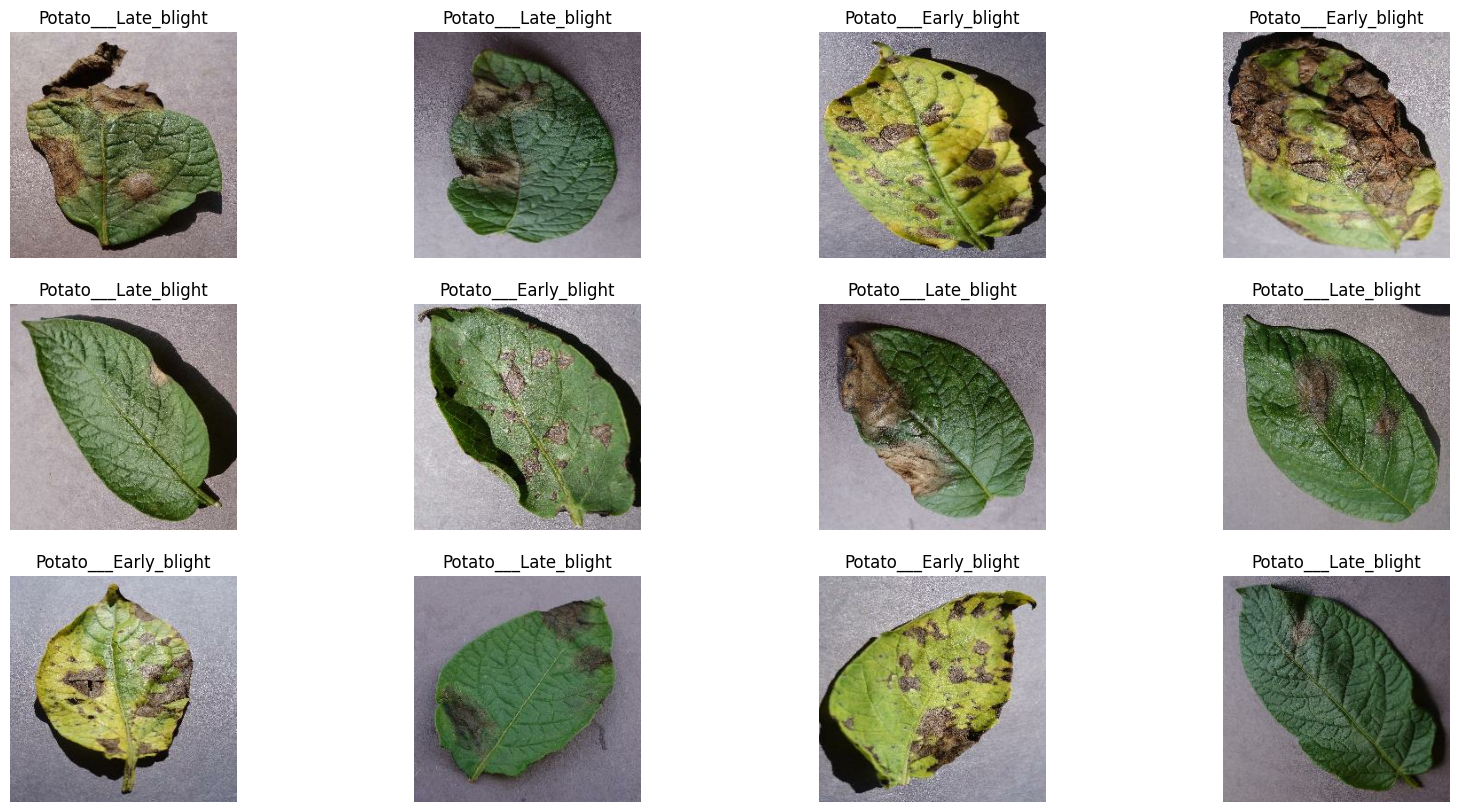

In [12]:
plt.figure(figsize=(20,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

In [13]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        assert (train_split + test_split + val_split) == 1

        ds_size=len(ds)#68
        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
        train_size=int(train_split*ds_size)#0.8*68=54
        val_size=int(val_split*ds_size)#0.1*68=6
        train_ds = ds.take(train_size) #54
        val_ds = ds.skip(train_size).take(val_size)#it will skip 54 and take 6
        test_ds = ds.skip(train_size).skip(val_size)#it will skip 54 and skip  6 and take 8
        return train_ds, val_ds, test_ds

In [14]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(Image_Size, Image_Size),
  layers.Rescaling(1./255),
])


In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),

])

In [21]:
input_shape = (Image_Size, Image_Size, Channels)
batch_input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
n_classes=3

In [22]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=batch_input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=Epochs,
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.4913 - loss: 0.9391 - val_accuracy: 0.4531 - val_loss: 0.9061
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5329 - loss: 0.8247 - val_accuracy: 0.6458 - val_loss: 0.7405
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.7514 - loss: 0.5801 - val_accuracy: 0.7708 - val_loss: 0.4714
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8366 - loss: 0.3859 - val_accuracy: 0.8490 - val_loss: 0.3492
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.8819 - loss: 0.3038 - val_accuracy: 0.9167 - val_loss: 0.2112
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.9081 - loss: 0.2248 - val_accuracy: 0.8906 - val_loss: 0.2550
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9136 - loss: 0.2234 - val_accuracy: 0.9167 - val_loss: 0.1974
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.9057 - loss: 0.2284 - val_accuracy: 0.9219 - v

In [26]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

[INFO] Calculating model accuracy
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.9876 - loss: 0.0489
Test Accuracy: 98.83%


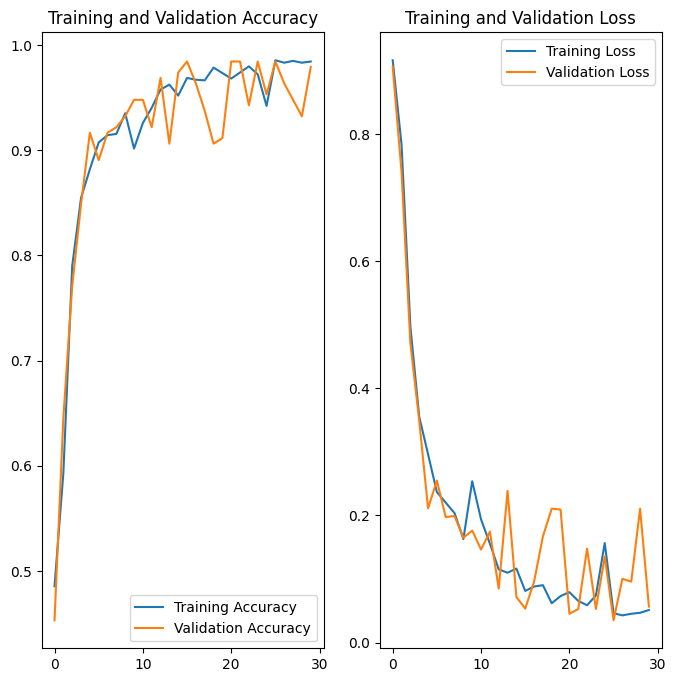

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


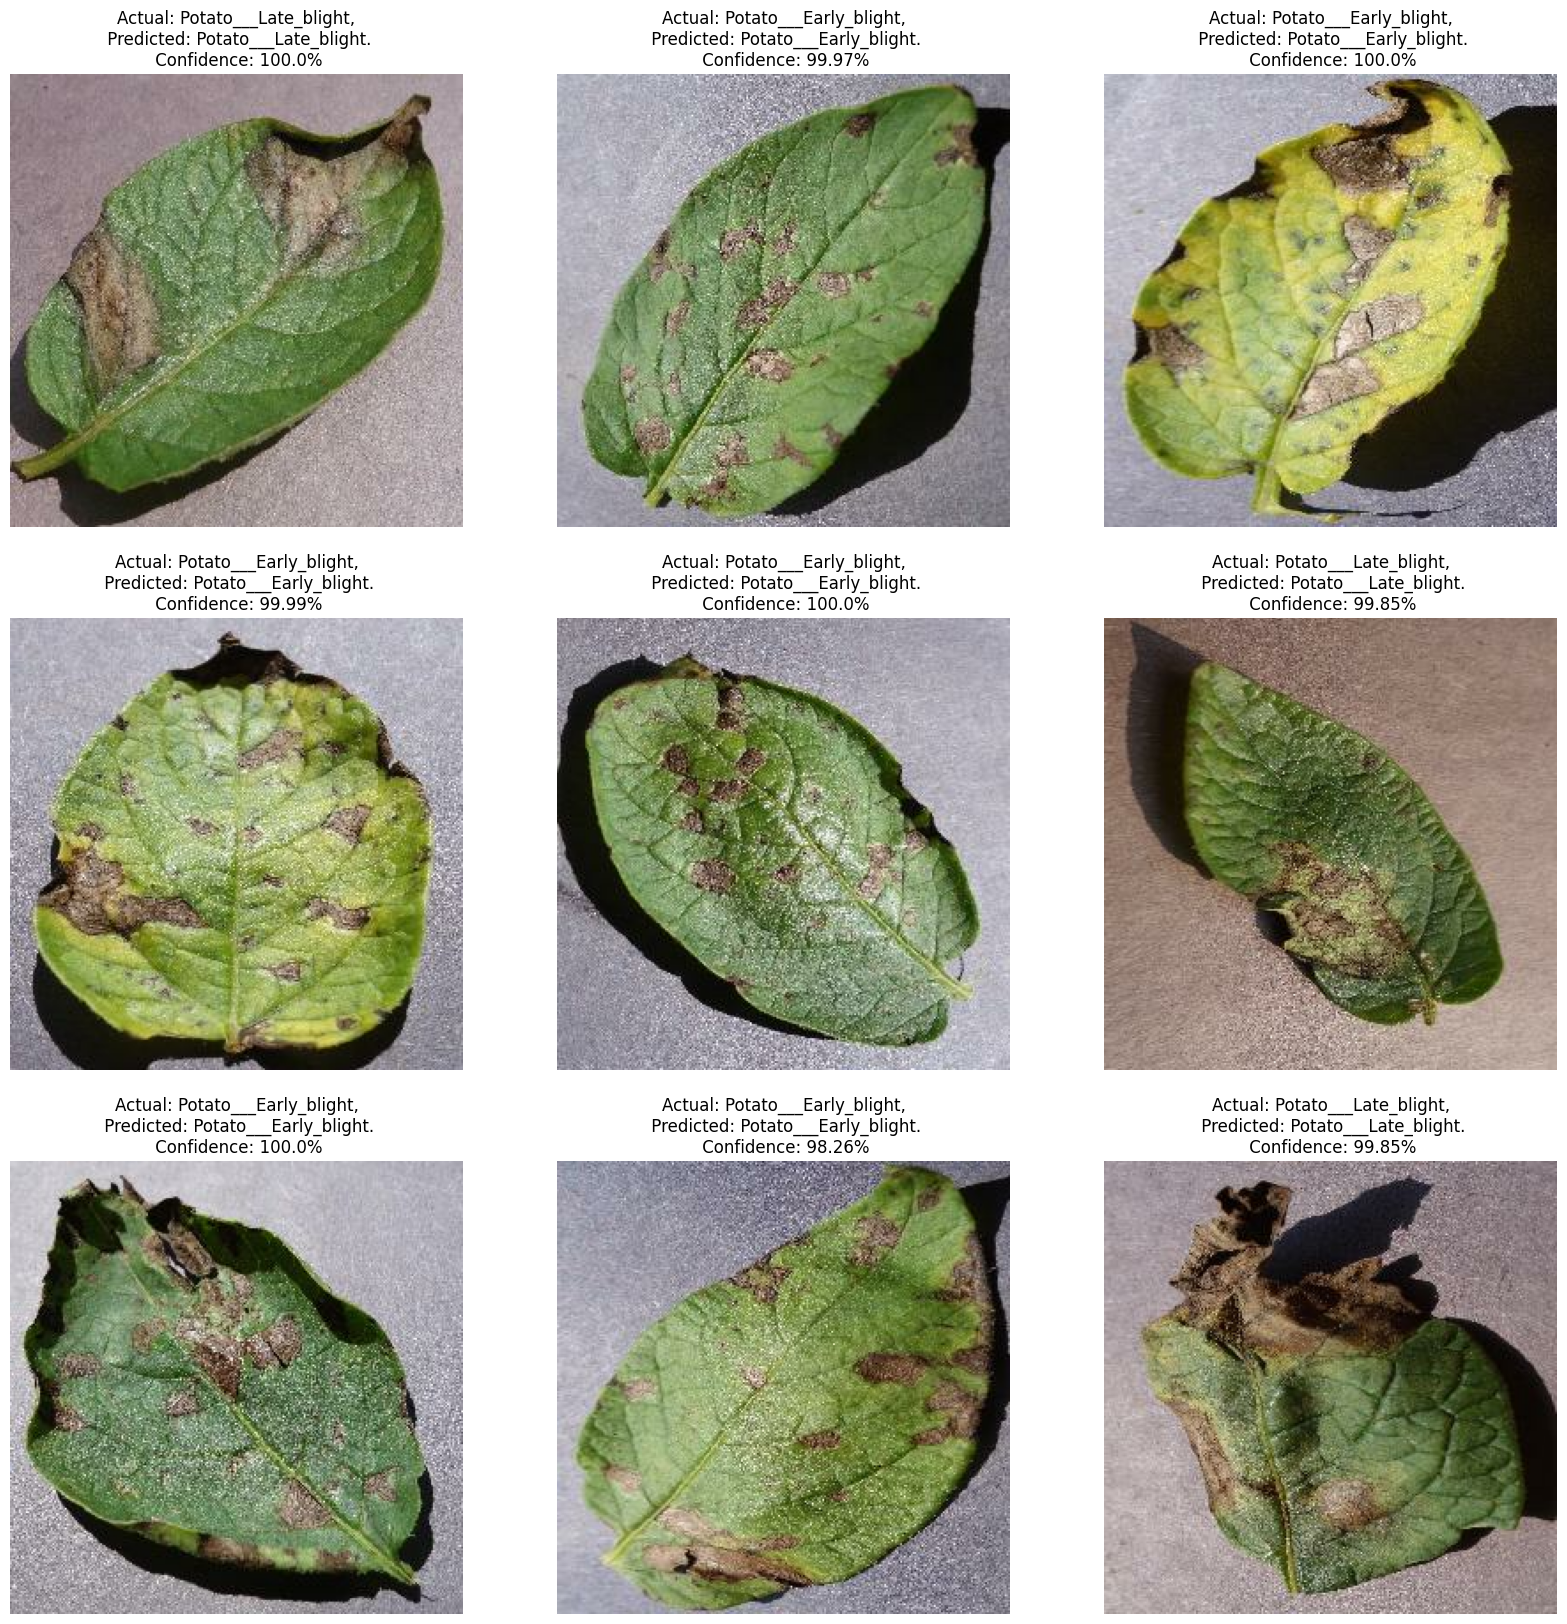

In [29]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        
        actual_class = class_name[labels[i]] 
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")